<a href="https://colab.research.google.com/github/saritmaitra/Natural-Gas_Paul/blob/master/Sarit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data mining approach**


## **Data ingestion, processing, feature engineering and machine learning**

In [0]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score, mean_squared_error
from xgboost import XGBClassifier, plot_importance
!pip install fredapi
from fredapi import Fred
!pip install EIA_python
import eia
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
import xgboost as xgb
!pip install ffn
import ffn

  Created wheel for pyforest: filename=pyforest-1.0.2-py2.py3-none-any.whl size=13556 sha256=96582a35b463c441ec2a784bcfe810eae49b1757228815c0edeebfd51e1e1f5e
  Stored in directory: /root/.cache/pip/wheels/e2/1b/b1/f7ff0a6aee79ec158aea4a339d7bd722deb261f65d8c9968c2
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22814 sha256=3b1241b8f8e1d7c6083cb9d9fcafe2a1fdc42a4c0213b8ffba407b2e45cf4ee3
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built ffn


/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## **Current Spot price ($/Mbtu)**


In [0]:
# Henry Hub Spot Price, Daily (Release Date: 3/11/2020; Next Release Date: 3/18/2020 )
print('\033[4mHenry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    hh_spot = pd.DataFrame(series_search)
    return hh_spot

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.RNGWHHD.D'
      hh_spot = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(hh_spot))
      return hh_spot;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

hh_spot = main()
hh_spot = hh_spot.rename({'Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)': 'hh_spot'}, axis = 'columns')
hh_spot = hh_spot.reset_index()
hh_spot['index'] = pd.to_datetime(hh_spot['index'].str[:-3], format='%Y %m%d')
hh_spot['Date']= pd.to_datetime(hh_spot['index']) 
hh_spot.set_index('Date', inplace=True) # setting index column
hh_spot = hh_spot.loc['2000-01-01':,['hh_spot']] # setting date range
hh_spot = hh_spot.astype(float)
#print(hh_spot) 
print('\n')


Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***Visualization***

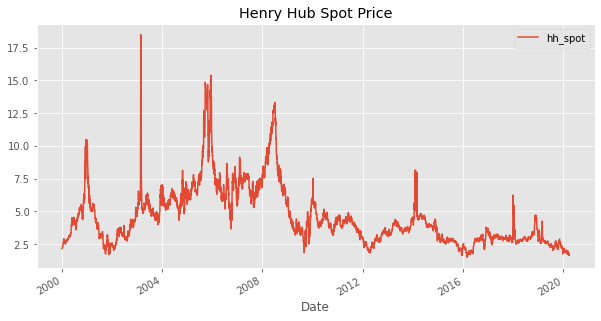

In [0]:
%matplotlib inline  
hh_spot.plot(figsize = (10,5), grid=True)
plt.title('Henry Hub Spot Price')
plt.show()

## **Natural Gas Continuius Contract**

In [0]:
# Natural Gas continuous contract
print('\033[4mNatural Gas continuous contract 1\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,]
#NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]


Natural Gas continuous contract 1


### ***Current price & visualization***

In [0]:
# new code
print('\033[4mCurrent spot price\033[0m')
print(hh_spot.tail(1))
print('\033[4mOpen price\033[0m')
print(NG['Open'].tail(1))
print('\n')
print('\033[4mClose price\033[0m')
print(NG['Last'].tail(1))
print('\n')
print('\033[4mAdj Close price\033[0m')
print(NG['Settle'].tail(1))
print('\n')
print('\033[4mHigh price\033[0m')
print(NG['High'].tail(1))
print('\n')
print('\033[4mLow price\033[0m')
print(NG['Low'].tail(1))
print('\n')
print('\033[4mVolume\033[0m')
print(NG['Volume'].tail(1))
print('\n')

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=NG.index,
                open=NG['Open'],
                high=NG['High'],
                low=NG['Low'],
                close=NG['Last'])])
fig.show()
print('\n')

# 4 WEEKS's OPEN AND CLOSE PRICE
ng = NG[['Open', 'Last', 'High', 'Low']].copy()
ng.tail(20)

Current spot price
            hh_spot
Date               
2020-03-30     1.65
Open price
Date
2020-04-06    1.65
Name: Open, dtype: float64


Close price
Date
2020-04-06    1.749
Name: Last, dtype: float64


Adj Close price
Date
2020-04-06    1.731
Name: Settle, dtype: float64


High price
Date
2020-04-06    1.755
Name: High, dtype: float64


Low price
Date
2020-04-06    1.63
Name: Low, dtype: float64


Volume
Date
2020-04-06    183843.0
Name: Volume, dtype: float64




,Open,Last,High,Low
Date,,,,
2020-03-10,1.835,1.924,1.955,1.794
2020-03-11,1.938,1.882,1.998,1.860
2020-03-12,1.883,1.819,1.883,1.750
2020-03-13,1.810,1.883,1.951,1.795
2020-03-16,1.854,1.804,1.854,1.778
2020-03-17,1.797,1.720,1.820,1.711
2020-03-18,1.721,1.635,1.728,1.555
2020-03-19,1.632,1.650,1.683,1.602
2020-03-20,1.647,1.577,1.700,1.574


In [0]:
NG.columns

Index(['Open', 'High', 'Low', 'Last', 'Change', 'Settle', 'Volume', 'Previous Day Open Interest'], dtype='object')

### ***Statistics 1***

In [0]:
perf = NG['Last'].copy().calc_stats()
print('\n')
perf.display()
print('\n')



Stats for Last from 2000-01-04 00:00:00 - 2020-04-03 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-23.76%             0.25  -1.33%  -89.91%

Annualized Returns:
mtd    3m       6m       ytd      1y       3y       5y      10y     incep.
-----  -------  -------  -------  -------  -------  ------  ------  --------
0.97%  -21.52%  -29.04%  -24.00%  -37.98%  -19.21%  -8.95%  -9.04%  -1.33%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.25     0.21       0.00
mean    13.96%   11.37%     0.13%
vol     56.01%   53.36%     41.91%
skew    1.53     0.70       0.65
kurt    22.54    2.02       0.09
best    58.02%   62.61%     86.34%
worst   -32.80%  -41.62%    -73.71%

Drawdowns:
max      avg       # days
-------  ------  --------
-89.91%  -9.89%    186.87

Misc:
---------------  -------
avg. up month    11.77%
avg. down month  -10.33%
up year 

In [0]:
p = pd.DataFrame(perf.display())
p

<IPython.core.display.Javascript object>

Stats for Last from 2000-01-04 00:00:00 - 2020-04-03 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-23.76%             0.25  -1.33%  -89.91%

Annualized Returns:
mtd    3m       6m       ytd      1y       3y       5y      10y     incep.
-----  -------  -------  -------  -------  -------  ------  ------  --------
0.97%  -21.52%  -29.04%  -24.00%  -37.98%  -19.21%  -8.95%  -9.04%  -1.33%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.25     0.21       0.00
mean    13.96%   11.37%     0.13%
vol     56.01%   53.36%     41.91%
skew    1.53     0.70       0.65
kurt    22.54    2.02       0.09
best    58.02%   62.61%     86.34%
worst   -32.80%  -41.62%    -73.71%

Drawdowns:
max      avg       # days
-------  ------  --------
-89.91%  -9.89%    186.87

Misc:
---------------  -------
avg. up month    11.77%
avg. down month  -10.33%
up year % 

""


In [0]:
#print('\033[4mMonthly returns\033[0m')
#print(perf.display_monthly_returns())
#perf.display_monthly_returns()
#print('\n')



Statistics
start                    2000-01-04 00:00:00
end                      2020-04-03 00:00:00
rf                                         0
total_return                       -0.237592
cagr                              -0.0133092
max_drawdown                       -0.899142
calmar                            -0.0148021
mtd                               0.00973828
three_month                        -0.215232
six_month                          -0.290419
ytd                                -0.240037
one_year                           -0.379813
three_year                         -0.192137
five_year                          -0.089521
ten_year                           -0.090393
incep                             -0.0133092
daily_sharpe                        0.249218
daily_sortino                       0.454011
daily_mean                           0.13958
daily_vol                           0.560072
daily_skew                           1.52553
daily_kurt                           22.54

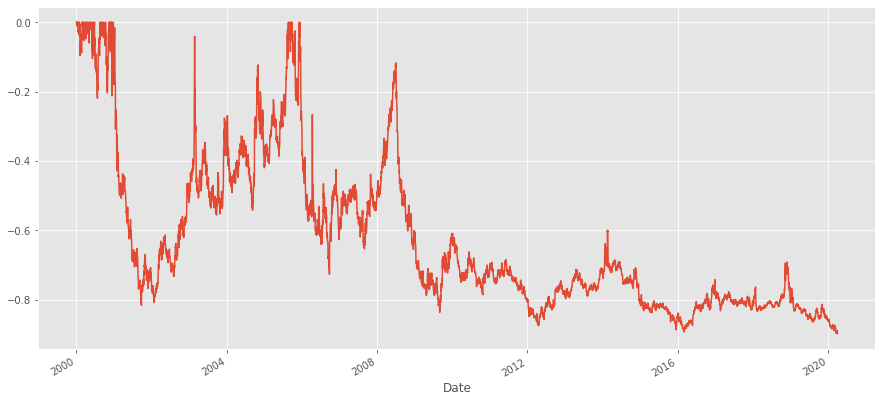

In [0]:
%matplotlib inline 

ffn.to_drawdown_series(NG['Last']).plot(figsize=(15,7),grid=True)
print('\n')

print('\033[4mStatistics\033[0m')
print(perf.stats)
print('\n')


### ***Statistics 2***

Average daily return: 0.0005537810846316639
Average Volatility: 0.03527775116420309
Annualized average return of Natural Gas (Contract#1): 0.14


<IPython.core.display.Javascript object>

Annualized volatility of Natural Gas (Contract#1): 0.56




<IPython.core.display.Javascript object>

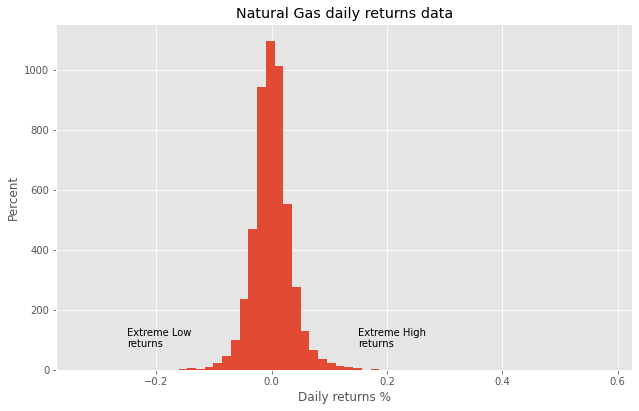



Maximum Drawdown
Maximum Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06    0.000000
2000-01-07   -0.010474
2000-01-10    0.000000
                ...   
2020-03-30   -0.406348
2020-03-31   -0.426927
2020-04-01   -0.445413
2020-04-02   -0.459016
2020-04-03   -0.421346
Name: Last, Length: 5078, dtype: float64


Min Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06   -0.003676
2000-01-07   -0.010474
2000-01-10   -0.010474
                ...   
2020-03-30   -0.559705
2020-03-31   -0.559705
2020-04-01   -0.559705
2020-04-02   -0.559705
2020-04-03   -0.559705
Name: Last, Length: 5078, dtype: float64




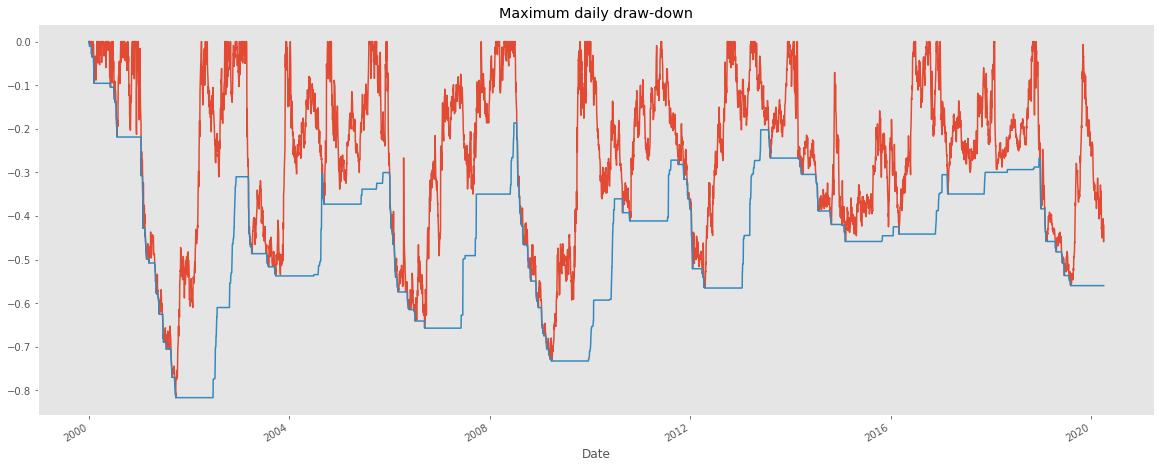

In [0]:
# Calculate the daily percentage change which is daily return
#print('\033[1m' + 'daily percentage change' + '\033[1m')
daily_ret = NG['Last'].pct_change().fillna(0)
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return:',   mean_return )
print('Average Volatility:',  return_stdev)

print ('Annualized average return of Natural Gas (Contract#1):', round(mean_return * 252,2))
print('Annualized volatility of Natural Gas (Contract#1):', round(return_stdev * np.sqrt(252), 2))
print('\n')


#print('\033[4mStatistics summary\033[0m')
#print(merge12.daily_ret.describe())
#print('\n')

#print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
#print ('t test statistic: ', test_statistic)
#print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
#print ('P-value is: ', p_val)
#print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
#print ('Critical value at α = 0.01 with 251 df: ', crit_value)
#print('\n')

# +/- %5 daily change distribution in Henry Hub gas prices
#daily_ret.hist(bins=100, range = (-0.05, 0.05), figsize = (15,8))
#plt.title('+/- 5% daily change distribution in Henry Hub gas prices')
#plt.show()
#print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.25,75,"Extreme Low\nreturns")
ax1.text(0.15,75,"Extreme High\nreturns")
plt.show()
print('\n')
#print ('\033[1m' + 'Shapiro test: W-test, and P-value' + '\033[1m')
#print(stats.shapiro(daily_ret))
#print('\n')
#print("Skewness, Kurtosis : ", daily_ret.skew(), daily_ret.kurtosis())
#print('\n')
#print("T-value P-value (two-tail)")
#print(stats.ttest_1samp(daily_ret, 0.5))
#print(stats.ttest_1samp(daily_ret, 0))
#print('\n')

print('\033[4mMaximum Drawdown\033[0m')

# Using a trailing 186 trading day window
window = 186

# Calculate the max drawdown in the past window days for each day in the series.
# using min_periods=1, we want to let the first 186 days data have an expanding window
roll_max = NG['Last'].rolling(min_periods=1, window=window).max()

# Calculate daily draw-down from rolling max
daily_drawdown = NG['Last']/roll_max - 1.0
print('\033[4mMaximum Daily Drawdown\033[0m')
print(daily_drawdown)
print('\n')

# Next we calculate the minimum (negative) daily drawdown in that window.
# using min_periods=1 to allow the expanding window
print('\033[4mMin Daily Drawdown\033[0m')
min_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
print(min_daily_drawdown)
print('\n')

# Plot the results
daily_drawdown.plot(figsize=(20,8))
min_daily_drawdown.plot()
#plt.title('Orange -> Daily running 186-day drawdown; Blue -> Max. experienced 186-day drawdown in the past year')
plt.title('Maximum daily draw-down')
plt.grid()
plt.show()
print('\n')

In [0]:
# empirical quantile of daily returns
import scipy.stats
print('\033[4mEmpirical quantile of daily returns\033[0m')
daily_ret.quantile(0.05)

Empirical quantile of daily returns


-0.04958467393667426

The 0.05 (p=0.05) empirical quantile of daily returns is at -0.0496. This means that with 95% confidence, the worst daily loss will not exceed 4.96% (of the investment).

As an example, if we have a USD 1M investment, our one-day 5% VaR is 0.0496 * USD 1M = USD 49.60 k

In [0]:
print('\033[4mAverage Sharpe Ratio (risk-adjusted return):: Daily\033[0m')
sharpe_ratio = daily_ret.mean() / daily_ret.std()
print('Sharpe Ratio:' +"{:.2f}".format(sharpe_ratio))
print('\n')

print('\033[4mSharpe Ratio:: Annual\033[0m')
an_sharpe_ratio = (252**0.5) * sharpe_ratio # annualised sharpe ratio
an_sharpe_ratio = round(an_sharpe_ratio,2)
print('Annualized Sharpe Ratio (risk-adjusted return):', an_sharpe_ratio)

Average Sharpe Ratio (risk-adjusted return):: Daily
Sharpe Ratio:0.02


Sharpe Ratio:: Annual
Annualized Sharpe Ratio (risk-adjusted return): 0.25


### ***Statistics 3***

In [0]:
print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)\033[0m')

print ("The probability of price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))
print('\n')

print('\033[4mMinimum price [2000- till date]\033[0m')
print(NG['Last'].min(), NG['Last'].idxmin());
print('\033[4mMaximum price [2000- till date]\033[0m')
print(NG['Last'].max(), NG['Last'].idxmax());
print('\n')

print('\033[4mMinimum daily % return [2000- till date]\033[0m')
print(daily_ret.min(), daily_ret.idxmin()); 
print('\033[4mMaximum daily % return [2000- till date]\033[0m')
print(daily_ret.max(), daily_ret.idxmax());
print('\n')

Probability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)
The probability of price changes between 1% and -1% is 28.48% 
The probability of price changes between 3% and -3% is 72.12% 
The probability of price changes between 5% and -5% is 89.29% 
The probability of price changes more than 5% is 5.92%
The probability of price changes less than -5% is 4.79%


Minimum price [2000- till date]
1.577 2020-03-20 00:00:00
Maximum price [2000- till date]
15.378 2005-12-13 00:00:00


Minimum daily % return [2000- till date]
-0.32798226164079824 2006-04-17 00:00:00
Maximum daily % return [2000- till date]
0.5802382620882973 2006-04-14 00:00:00




# **Importing API's**

### Data Pipeline

In [0]:
# Cushing, OK WTI Spot Price FOB, Daily
print('\033[4mWTI Spot Price FOB, Daily (Dollars per Barrel)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    wti = pd.DataFrame(series_search)
    return wti

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.RWTC.D'
      wti = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(wti))
      return wti;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

wti = main()
wti = wti.rename({'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)': 'wti'}, axis = 'columns')
wti = wti.reset_index()
wti['index'] = pd.to_datetime(wti['index'].str[:-3], format='%Y %m%d')
wti['Date']= pd.to_datetime(wti['index']) 
wti.set_index('Date', inplace=True) # setting index column
wti = wti.loc['2000-01-01':,['wti']] # setting date range
wti = wti.astype(float)
#print(wti) 
#print('\n')

## GDP data
print('\033[4mUS GDP Data\033[0m')
fred = Fred(api_key='59c798fcda5850ef874412d269fd2378')
gdp = fred.get_series_as_of_date('GDP', '2020-01-31')
gdp = gdp.rename({'date': 'Date', 'value': 'gdp'}, axis = 'columns')
gdp.set_index('Date', inplace=True) # setting index column
gdp = gdp.loc['2000-01-01':'2020-02-02',['gdp']] # setting date range
gdp.replace({pd.NaT: "0"}, inplace=True) # replacing NaT with 0
gdp = gdp.ffill().bfill()
gdp = gdp.reset_index().drop_duplicates('Date').set_index('Date') # dropping duplicate concurrence
gdp = pd.DataFrame(gdp)
gdp = gdp.astype(float)
gdp = gdp.resample('B').ffill()
gdp = gdp/4
#print(gdp)
#print('\n')

# U.S. Natural Gas Marketed Production, Monthly
print('\033[4mNatural Gas Marketed Production, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    prod = pd.DataFrame(series_search)
    return prod

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9050US2.M'
      prod = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(prod))
      return prod;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

prod = main()
prod = prod.rename({'U.S. Natural Gas Marketed Production, Monthly (Million Cubic Feet)': 'prod'}, axis = 'columns')
prod = prod.reset_index()
prod['Date']= pd.to_datetime(prod['index']) 
prod.set_index('Date', inplace=True) # setting index column
prod = prod.loc['2000-01-01':,['prod']] # setting date range
prod = prod.astype(float)
prod = prod.resample('B').ffill()
prod = prod/21
#print(prod)
#print('\n')


# U.S. Natural Gas Gross Withdrawals, Monthly
print('\033[4mNatural Gas Gross Withdrawals, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    withdrawals = pd.DataFrame(series_search)
    return withdrawals

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9010US2.M' 
      withdrawals = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(withdrawals))
      return withdrawals;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

withdrawals = main()
withdrawals = withdrawals.rename({'U.S. Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)': 'withdrawals'}, axis = 'columns')
withdrawals = withdrawals.reset_index()
withdrawals['Date']= pd.to_datetime(withdrawals['index']) 
withdrawals.set_index('Date', inplace=True) # setting index column
withdrawals = withdrawals.loc['2000-01-01':,['withdrawals']] # setting date range
withdrawals = withdrawals.astype(float)
withdrawals = withdrawals.resample('B').bfill().ffill()
withdrawals = withdrawals/21
#print(withdrawals)
#print('\n')

# U.S. Natural Gas Underground Storage Volume, Monthly
print('\033[4mNatural Gas Underground Storage Volume, Monthly\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    storage = pd.DataFrame(series_search)
    return storage

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N5030US2.M '
      storage = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(storage))
      return storage;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

storage = main()
storage = storage.rename({'U.S. Natural Gas Underground Storage Volume, Monthly (Million Cubic Feet)': 'storage'}, axis = 'columns')
storage = storage.reset_index()
storage['Date']= pd.to_datetime(storage['index']) 
storage.set_index('Date', inplace=True) # setting index column
storage = storage.loc['2000-01-01':,['storage']] # setting date range
stoarge = storage.astype(float)
storage = storage.resample('B').bfill().ffill()
storage = storage/21
#print(storage)
#print('\n')

# U.S. Natural Gas Exports, Monthly
print('\033[4mNatural Gas Exports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    export = pd.DataFrame(series_search)
    return export

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9133US2.M'
      export = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(export))
      return export;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

export = main()
export = export.rename({'Liquefied U.S. Natural Gas Exports, Monthly (Million Cubic Feet)': 'export'}, axis = 'columns')
export = export.reset_index()
export['Date']= pd.to_datetime(export['index']) 
export.set_index('Date', inplace=True) # setting index column
export = export.loc['2000-01-01':,['export']] # setting date range
export = export.astype(float)
export = export.resample('B').bfill().ffill()
export = export/21
#print(export)
#print('\n')

# natural gas total consumption (monthly))
print('\033[4mNatural Gas Total Consumption, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    consumption = pd.DataFrame(series_search)
    return consumption

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9140US2.M'
      consumption = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(consumption))
      return consumption;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

consumption = main()
consumption = consumption.rename({'U.S. Natural Gas Total Consumption, Monthly (Million Cubic Feet)': 'consumption'}, axis = 'columns')
consumption = consumption.reset_index()
consumption['Date']= pd.to_datetime(consumption['index']) 
consumption.set_index('Date', inplace=True) # setting index column
consumption = consumption.loc['2000-01-01':,['consumption']] # setting date range
consumption = consumption.astype(float)
consumption = consumption.resample('B').ffill().bfill()
consumption = consumption/21
#print(consumption)
#print('\n')

# New York Harbor No. 2 Heating Oil Spot Price FOB, Monthly
print('\033[4mHeating Oil Spot Price FOB, Daily (Dollars per Gallon)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    heatingoil = pd.DataFrame(series_search)
    return heatingoil

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.EER_EPD2F_PF4_Y35NY_DPG.D'
      heatingoil = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(heatingoil))
      return heatingoil;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

heatingoil = main()
heatingoil = heatingoil.rename({'New York Harbor No. 2 Heating Oil Spot Price FOB, Daily (Dollars per Gallon)': 'heatingoil'}, axis = 'columns')
heatingoil = heatingoil.reset_index()
heatingoil['index'] = pd.to_datetime(heatingoil['index'].str[:-3], format='%Y %m%d')
heatingoil['Date']= pd.to_datetime(heatingoil['index']) 
heatingoil.set_index('Date', inplace=True) # setting index column
heatingoil = heatingoil.loc['2000-01-01':,['heatingoil']] # setting date range
heatingoil = heatingoil.astype(float)
#print(heatingoil)
#print('\n')

# natural gas import dat
#print('\033[4mNatural Gas Imports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    g_import = pd.DataFrame(series_search)
    return g_import

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9100US2.M'
      g_import = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(g_import))
      return g_import;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
g_import = main()
g_import = g_import.rename({'U.S. Natural Gas Imports, Monthly (Million Cubic Feet)': 'g_import'}, axis = 'columns')
g_import = g_import.reset_index()
g_import['Date']= pd.to_datetime(g_import['index']) 
g_import.set_index('Date', inplace=True) # setting index column
g_import = g_import.loc['2000-01-01':,['g_import']] # setting date range
g_import = g_import.astype(float)
g_import = g_import.resample('B').ffill().bfill()
g_import = g_import/21
#print(g_import)
#print('\n')

# U.S. Natural Gas Rotary Rigs in Operation, Monthly
print('\033[4mNatural Gas Rotary Rigs in Operation, Monthly (Number of Elements)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    drilling = pd.DataFrame(series_search)
    return drilling

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.E_ERTRRG_XR0_NUS_C.M '
      drilling = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(drilling))
      return drilling;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
drilling = main()
drilling = drilling.rename({'U.S. Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)': 'drilling'}, axis = 'columns')
drilling = drilling.reset_index()
drilling['Date']= pd.to_datetime(drilling['index']) 
drilling.set_index('Date', inplace=True) # setting index column
drilling = drilling.loc['2000-01-01':,['drilling']] # setting date range
drilling = drilling.astype(float)
drilling = drilling.resample('B').ffill().bfill()
drilling = drilling/21
#print(drilling)
#print('\n')

# Heating Degree Days U.S. Average , Monthly
print('\033[4mHeating Degree Days U.S. Average , Monthly (total degree days)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    HDD_US = pd.DataFrame(series_search)
    return HDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='STEO.ZWHDPUS.M'
      HDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(HDD_US))
      return HDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
HDD_US = main()
HDD_US = HDD_US.rename({'Heating Degree Days U.S. Average , Monthly (total degree days)': 'HDD_US'}, axis = 'columns')
HDD_US = HDD_US.reset_index()
HDD_US['Date']= pd.to_datetime(HDD_US['index']) 
HDD_US.set_index('Date', inplace=True) # setting index column
HDD_US = HDD_US.loc['2000-01-01':,['HDD_US']] # setting date range
HDD_US = HDD_US.astype(float)
HDD_US = HDD_US.resample('B').ffill().bfill()
HDD_US = HDD_US/21
#print(HDD_US)
#print('\n')

# Cooling Degree-Days, United States, Monthly
print('\033[4mCooling Degree-Days, United States, Monthly (Number)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    CDD_US = pd.DataFrame(series_search)
    return CDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='TOTAL.ZWCDPUS.M'
      CDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(CDD_US))
      return CDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
CDD_US = main()
CDD_US = CDD_US.rename({'Cooling Degree-Days, United States, Monthly (Number)': 'CDD_US'}, axis = 'columns')
CDD_US = CDD_US.reset_index()
CDD_US['Date']= pd.to_datetime(CDD_US['index']) 
CDD_US.set_index('Date', inplace=True) # setting index column
CDD_US = CDD_US.loc['2000-01-01':,['CDD_US']] # setting date range
CDD_US = CDD_US.astype(float)
CDD_US = CDD_US.resample('B').ffill().bfill()
CDD_US = CDD_US/21
#print(CDD_US)
#print('\n')



WTI Spot Price FOB, Daily (Dollars per Barrel)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

US GDP Data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natural Gas Marketed Production, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Underground Storage Volume, Monthly


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Exports, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Total Consumption, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Oil Spot Price FOB, Daily (Dollars per Gallon)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Degree Days U.S. Average , Monthly (total degree days)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Cooling Degree-Days, United States, Monthly (Number)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

### ***Feature Engineering***

In [0]:
# merging data frames
merge1 = NG.join(gdp, how='left').ffill().bfill()
merge2 = merge1.join(wti, how = 'left')
merge3 = merge2.join(withdrawals, how = 'left').ffill().bfill()
merge4 = merge3.join(storage, how = 'left').ffill().bfill()
merge5 = merge4.join(prod, how = 'left').ffill().bfill()
merge6 = merge5.join(consumption, how = 'left').ffill().bfill()
merge7 = merge6.join(heatingoil, how ='left').ffill().bfill()
merge8 = merge7.join(drilling, how = 'left').ffill().bfill()
merge9 = merge8.join(export, how = 'left').ffill().bfill()
merge10 = merge9.join(g_import, how = 'left').ffill().bfill()
merge11 = merge10.join(HDD_US, how = 'left').ffill().bfill()
merge12 = merge11.join(CDD_US, how = 'left').ffill().bfill()

# feature engineering
merge12['day_of_week'] = merge12.index.dayofweek
merge12['day_of_month'] = merge12.index.day
merge12['quarter'] = merge12.index.quarter
merge12['month'] = merge12.index.month
merge12['year'] = merge12.index.year

merge13 = merge12.apply(copy.deepcopy)
#print(merge13)

# Technical indicators
merge13['daily_ret'] = merge13['Open'].pct_change()
merge13['volatility'] = merge13['daily_ret'].rolling(252).std()*(252**0.5)
#merge13["close_1"] = merge13['Last'].shift(1)
#merge13["close_incr"] = merge13['Last'] - merge13['Last'].shift(1)
merge13['price_diff'] = merge13['Last'] - merge13['Open']
merge13["vol_increment"] = merge13['Volume'].diff()
merge13["vol_rel_increment"] = merge13['Volume'].diff() / merge13['Volume']

sma1 = 20
sma2 = 100
merge13["sma1"] = merge13['Last'].rolling(sma1).mean()
merge13["sma2"] = merge13['Last'].rolling(sma2).mean()
#merge13['ema42'] = merge13['Open'].ewm(span=42).mean()
#merge13['ema252'] = merge13['Open'].ewm(span=252).mean()

merge13['ema_12'] = merge13['Last'].ewm(span=10).mean()
merge13['ema_26'] = merge13['Last'].ewm(span=26).mean()
merge13['ROC'] = ((merge13['Last'] - merge13['Last'].shift(5)) / (merge13['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge13['rsi'] = 100-100/(1+RS_up/RS_down)
merge13['macd'] = merge13['ema_12'] - merge13['ema_26']

#print('\033[4mMerged dataframe\033[0m')
#print(df.info())
#print('\n')


#print('\033[4mProcessed dataframe\033[0m')
df = merge13.apply(copy.deepcopy)
#df.fillna(-99999, inplace=True)
#print(df)
#print(df.info())
#print('\n')


## **Adding more features**

### ***WIndow Features***
Adding lag features (sliding window method), here a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. 

In [0]:
df['t-2'] = df['Last'].shift(3)
df['t-1'] = df['Last'].shift(2)
df['t+1'] = df['Last'].shift(1)
#df.head()

### ***Rolling Window Statistics***
Adding a summary of the values at previous time steps. We will calculate summary statistics across the values in the sliding window and include these as features in our dataset. The most useful is the mean of the previous values, also called the rolling mean.

In [0]:
width = 3
shifted = df['Last'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df['min'] = roll_window.min()
df['mean'] = roll_window.mean()
df['max'] = roll_window.max()
#df.head()


### **Expanding Window Statistics**
Expanding window also can help with keeping track of the bounds of observable data.

In [0]:
exp_window = df['Last'].expanding()
df['min_exp'] = exp_window.min()
df['mean_exp'] = exp_window.mean()
df['max_exp'] = exp_window.max()
#df.head()

#df.fillna(-99999, inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5079 entries, 2000-01-04 to 2020-04-06
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5079 non-null   float64
 1   High                        5079 non-null   float64
 2   Low                         5079 non-null   float64
 3   Last                        5079 non-null   float64
 4   Change                      5079 non-null   float64
 5   Settle                      5079 non-null   float64
 6   Volume                      5079 non-null   float64
 7   Previous Day Open Interest  5079 non-null   float64
 8   gdp                         5079 non-null   float64
 9   wti                         5079 non-null   float64
 10  withdrawals                 5079 non-null   float64
 11  storage                     5079 non-null   float64
 12  prod                        5079 non-null   float64
 13  consumption    

## **Classification Algo (Buy & Sell signals)**

### ***Time-series cross validation***

In [0]:
""" run this section just once """

# Target Variable
print('\033[4mThis is a classification variable, average price will go either up or down the next day.\033[0m')
#This will be a classification variable, if the average price will go either up or down the next day.  
#The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).

df['target'] = (df['sma1'].shift(-1) - df['sma1'])
#df.fillna(0,inplace=True)
df['target'].tail()
#print('\n')

#The target variables will be transformed for binary classification.
def getBinary(val):
    if val > 0:
      return 1
    else:
      return 0
df['next_day_direction'] = df["target"].apply(getBinary)
print('\033[4mThe target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.\033[0m')

#print(df.tail())
#print('\n')

y = df['next_day_direction'].copy()
x = df.copy().drop(['next_day_direction', 
                    'target', 
                    'Last', 
                    'High', 
                    'Low', 
                    'Volume', 
                    'Settle', 
                    'Change', 
                    'Previous Day Open Interest',
                    'day_of_week', 
                    'day_of_month', 
                    'HDD_US', 
                    'quarter', 
                    'year'], axis=1)

X = np.array(x)
y = np.array(y)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # convert the numpy arrays into Pandas DataFrames so they are easier to explore and work with
  X_train = pd.DataFrame(data=X_train, index=train_index)
  y_train = pd.Series(data=y_train, index=train_index)
  X_test = pd.DataFrame(data=X_test, index=test_index)
  y_test = pd.Series(data=y_test, index=test_index)

eval_set = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]


This is a classification variable, average price will go either up or down the next day.
The target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***Hyperparameter optimization***

In [0]:
xgb_clf1 = XGBClassifier()
# Hyperparameter optimization
xgb = xgb_clf1.fit(X_train, y_train, 
                   early_stopping_rounds=10,  
                   eval_metric="logloss", 
                   eval_set=[(X_test, y_test)])

# scores
from  sklearn.metrics import log_loss
log_train = log_loss(y_train, xgb.predict_proba(X_train)[:,1])
log_valid = log_loss(y_test, xgb.predict_proba(X_test)[:,1])


print('\n-----------------------')
print('  logloss train: %.5f'%log_train)
print('  logloss valid: %.5f'%log_valid)
print('-----------------------')

print('\nModel parameters...')
print(xgb.get_params())

[0]	validation_0-logloss:0.640243
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.597248
[2]	validation_0-logloss:0.560512
[3]	validation_0-logloss:0.532028
[4]	validation_0-logloss:0.505843
[5]	validation_0-logloss:0.482279
[6]	validation_0-logloss:0.462734
[7]	validation_0-logloss:0.445098
[8]	validation_0-logloss:0.430299
[9]	validation_0-logloss:0.417157
[10]	validation_0-logloss:0.406482
[11]	validation_0-logloss:0.395667
[12]	validation_0-logloss:0.388181
[13]	validation_0-logloss:0.380233
[14]	validation_0-logloss:0.372643
[15]	validation_0-logloss:0.367367
[16]	validation_0-logloss:0.363865
[17]	validation_0-logloss:0.360088
[18]	validation_0-logloss:0.354181
[19]	validation_0-logloss:0.351229
[20]	validation_0-logloss:0.349791
[21]	validation_0-logloss:0.346975
[22]	validation_0-logloss:0.341958
[23]	validation_0-logloss:0.339577
[24]	validation_0-logloss:0.338361
[25]	validation_0-logloss:0.336456
[26]	validation_0-logloss:0.3356

### ***Model development***

In [0]:
# Set the hyperparameters

base_score = 0.5
colsample_bylevel = 1
colsample_bytree = 1
gamma = 0
learning_rate = 0.1
max_depth = 3
min_child_weight = 1
n_estimators = 100
subsample =1
colsample_bytree = 0.5
gamma = 1
random_state = 42


xgb_clf1 = XGBClassifier(learning_rate= learning_rate,
                         base_score = base_score,
                         max_depth= max_depth,
                         min_child_weight= min_child_weight,
                         n_estimators= n_estimators,
                         subsample =subsample,
                         colsample_bytree = colsample_bytree,
                         gamma = gamma,
                         random_state = random_state)


xgb_clf1.fit(X_train, y_train, 
             eval_metric = 'auc', eval_set = eval_set,
             early_stopping_rounds = 5, verbose = 10)

[0]	validation_0-auc:0.70163	validation_1-auc:0.541158
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.946421	validation_1-auc:0.940113
Stopping. Best iteration:
[10]	validation_0-auc:0.946421	validation_1-auc:0.940113



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### ***Classifier Performance***

Model performance :: Quality of Classifier


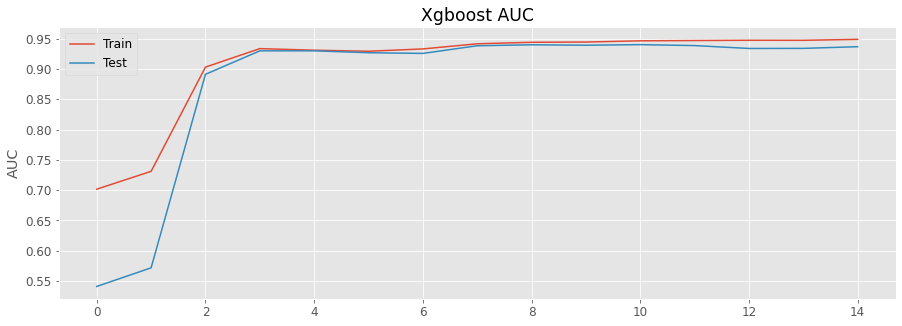

In [0]:
%matplotlib inline 
print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf1.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [0]:
# we can then access the best number of tree and use it later for prediction
print('best iteration', xgb_clf1.best_ntree_limit)
print('\n')

best iteration 11




### ***Features importance***

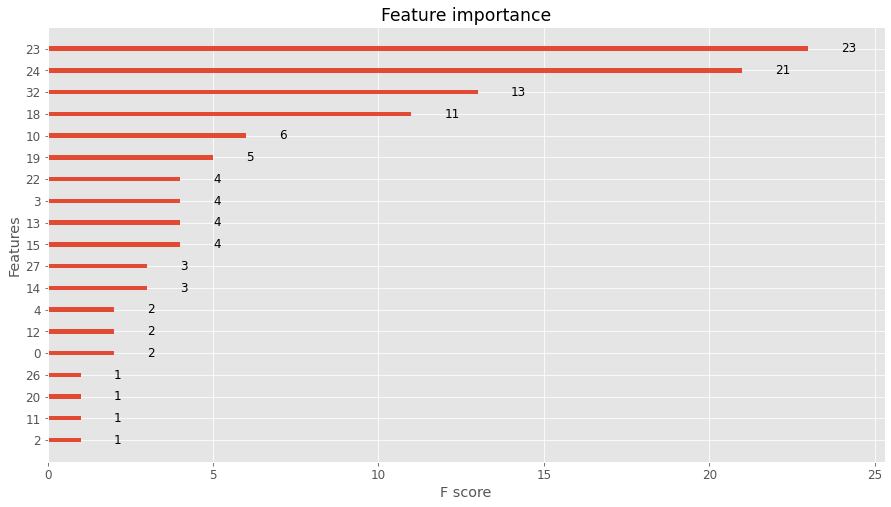

In [0]:
# Feature importance
plt.rcParams['figure.figsize'] = [15, 8]
plot_importance(xgb_clf1)
print('\n')

In [0]:
#fig = plt.figure(figsize=(20,6))
#plt.xticks(rotation='vertical')
#plt.bar([i for i in range(len(xgb_clf1.feature_importances_))], xgb_clf1.feature_importances_.tolist(), 
        #tick_label=x.columns, color="chocolate")
#plt.title('Feature importance plot')
#plt.show()
#print('\n')

### ***Prediction probability***
The predicted probability are the votes, i.e. the proportion of trees who voted for class 1 & 0. We have 5 trees, our values could only be multiples of 0.2.

In [0]:
# print the model's performance
ntree_limit = xgb_clf1.best_ntree_limit
xgb_clf1.predict_proba(X_test[:5], ntree_limit = ntree_limit)

array([[0.40470642, 0.5952936 ],
       [0.34012753, 0.6598725 ],
       [0.31203347, 0.6879665 ],
       [0.29249012, 0.7075099 ],
       [0.29883885, 0.70116115]], dtype=float32)

### ***Area Under Curve (AUC)***

In [0]:
pred_prob = xgb_clf1.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', round(roc_auc_score(y_test, pred_prob)*100, 2))
print('\n')

Area under ROC curve: 94.01




In [0]:
# print the model's performance
ntree_limit = xgb_clf1.best_ntree_limit
#print('\033[4mNext day Open price direction\033[0m')
pred = xgb_clf1.predict(X_test, ntree_limit = ntree_limit)
pred = pd.DataFrame(pred)
print(pred.tail())
print('\n')

print('\033[4mProbability of prediction results\033[0m')
pred_prob = pd.DataFrame(pred_prob)
print(round(pred_prob.tail(),2))
#print('\n')



<IPython.core.display.Javascript object>

     0
841  0
842  0
843  0
844  0
845  0


Probability of prediction results


<IPython.core.display.Javascript object>

        0
841  0.31
842  0.30
843  0.29
844  0.31
845  0.45


### ***BUY/SELL signal plot***

For each day where open price = 0 = red arrow head  and 1 = green arrow head 


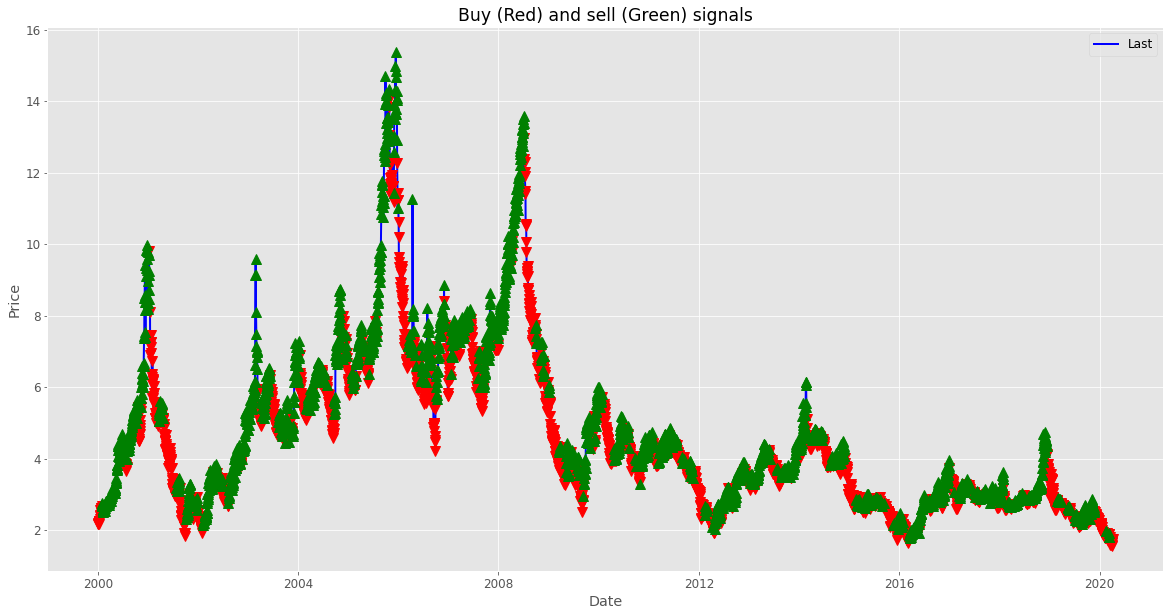

In [0]:
# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 

print('\033[4mFor each day where open price = 0 = red arrow head  and 1 = green arrow head \033[0m')
buys = df.loc[df['next_day_direction'] == 0]
sells = df.loc[df['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,10))
plt.plot(df.index, df['Last'], color = 'b', lw=2., label='Last')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Last'], 'v', markersize=10, color='r')
plt.plot(sells.index, df.loc[sells.index]['Last'], '^', markersize=10, color='g')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy (Red) and sell (Green) signals')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')




In [0]:
# Last 5 Buy & Sell signals
print('\033[4mLast 5 Buy signal \033[0m')
print(round(df.loc[buys.index], 2)['Last'].tail())
print('\n')
print('\033[4mLast 5 Sell signal \033[0m')
print(round(df.loc[sells.index], 2)['Last'].tail())
print('\n')


Last 5 Buy signal 
Date
2020-03-31    1.64
2020-04-01    1.59
2020-04-02    1.55
2020-04-03    1.66
2020-04-06    1.75
Name: Last, dtype: float64


Last 5 Sell signal 
Date
2020-02-18    1.97
2020-02-19    1.97
2020-03-09    1.82
2020-03-10    1.92
2020-03-12    1.82
Name: Last, dtype: float64




In [0]:
# assigning date to the predicted values
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in pred:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(df['Forecast'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=df['Forecast'].index[0].date(), end=df['Forecast'].index[-1].date())

#Filter the series to just those days contained in the business day range.
df['Forecast'] = df.Forecast[ts_days.isin(bdays)]
print('\033[4mNext day Open price direction\033[0m')
df['Forecast'].tail()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next day Open price direction


Date
2020-04-01    NaN
2020-04-02    NaN
2020-04-03    NaN
2020-04-06    NaN
2020-04-07    0.0
Name: Forecast, dtype: float64

## **Moving averages crossover**

<IPython.core.display.Javascript object>

Sell-> Shorter MA crosses above the longer-term MA (Golden cross)
Buy-> Shorter MA crosses below the longer-term MA(Dead cross)


Buys data to checking
Date
2020-03-31    1.643
2020-04-01    1.590
2020-04-02    1.551
2020-04-03    1.659
2020-04-06    1.749
Name: Last, dtype: float64


Sells data to checking
Date
2019-02-12    2.667
2019-02-13    2.588
2019-02-14    2.567
2019-02-15    2.632
2019-02-19    2.659
Name: Last, dtype: float64


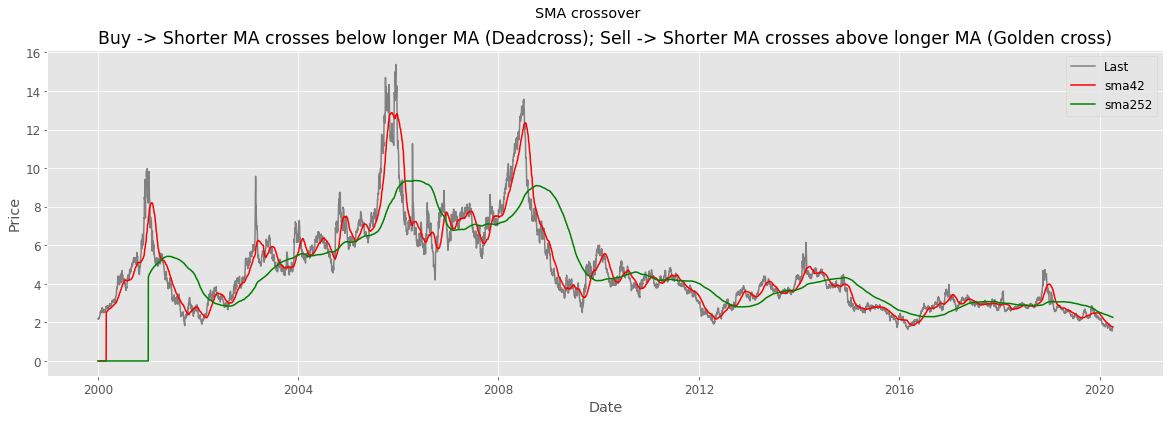

In [0]:
## Moving averages crossover [2 months and 1 year look back]
merge14 = merge12.apply(copy.deepcopy)

# feature engineering
merge14['day_of_week'] = merge14.index.dayofweek
merge14['day_of_month'] = merge14.index.day
merge14['quarter'] = merge14.index.quarter
merge14['month'] = merge14.index.month
merge14['year'] = merge14.index.year

# Technical indicators
merge14['daily_ret'] = merge14['Last'].pct_change()
#merge14['volatility'] = merge14['daily_ret'].rolling(252).std()*(252**0.5)
merge14["Last_1"] = merge14['Last'].shift(1)
merge14["Last_incr"] = merge14['Last'] - merge14['Last'].shift(1)
merge14['price_diff'] = merge14['Last'] - merge14['Open']
merge14["vol_increment"] = merge14['Volume'].diff()
merge14["vol_rel_increment"] = merge14['Volume'].diff() / merge14['Volume']

sma1 = 42
sma2 = 252
merge14["sma1"] = merge14['Last'].rolling(sma1).mean().fillna(0)
merge14["sma2"] = merge14['Last'].rolling(sma2).mean().fillna(0)
merge14['ema42'] = merge14['Last'].ewm(span=42).mean().fillna(0)
merge14['ema252'] = merge14['Last'].ewm(span=252).mean().fillna(0)

merge14['ema_12'] = merge14['Last'].ewm(span=10).mean().fillna(0)
merge14['ema_26'] = merge14['Last'].ewm(span=26).mean().fillna(0)
merge14['ROC'] = ((merge14['Last'] - merge14['Last'].shift(5)) / (merge14['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge14['rsi'] = 100-100/(1+RS_up/RS_down)
merge14['macd'] = merge14['ema_12'] - merge14['ema_26']


df1 = merge14.apply(copy.deepcopy)
#df1.fillna(-99999, inplace=True)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma1'] > df1['sma2'], 1,0)
#df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
df1['next_day_direction'] = df1["target"].apply(getBinary)


print('\033[4mSell-> Shorter MA crosses above the longer-term MA (Golden cross)\033[0m')
print('\033[4mBuy-> Shorter MA crosses below the longer-term MA(Dead cross)\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]
print('\n')

print("\033[4mBuys data to checking\033[0m")
print(df1.loc[buys.index]['Last'].tail())
print('\n')
print("\033[4mSells data to checking\033[0m")
print(df1.loc[sells.index]['Last'].tail())

# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(merge14['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
#  When the shorter-term MA crosses above the longer-term MA (Golden cross), it's a buy signal, it indicates that the trend is shifting up. 
#  When the shorter-term MA crosses below the longer-term MA, it's a sell signal (dead/death cross), it indicates that the trend is shifting down. 
plt.plot(merge14['sma1'].dropna(), color='r', label = 'sma42')
plt.plot(merge14['sma2'].dropna(), color='g', label = 'sma252')
plt.ylabel('Price')
plt.xlabel('Date')
plt.suptitle('SMA crossover')
plt.title('Buy -> Shorter MA crosses below longer MA (Deadcross); Sell -> Shorter MA crosses above longer MA (Golden cross)')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')


## **5 days look-ahead Open price**


### ***Feature engineering (Open variable)***

In [0]:
## 5 days look-ahead Open price

# Technical indicators
merge16 = merge12.apply(copy.deepcopy)

merge16['pct_change'] = merge16['Open'].pct_change()
merge16["vol_rel_increment"] = merge16['Volume'].diff() / merge16['Volume']
merge16['std_5'] = merge16['pct_change'].rolling(5).std()
merge16['ret_5'] = merge16['pct_change'].rolling(5).mean()
merge16['sma42'] = merge16['Open'].rolling(42).mean()
merge16['sma252'] = merge16['Open'].rolling(252).mean()
merge16['ema_12'] = merge16['Open'].ewm(span=10).mean()
merge16['ema_26'] = merge16['Open'].ewm(span=26).mean()
merge16['ROC'] = ((merge16['Open'] - merge16['Open'].shift(5)) / (merge16['Open'].shift(5)))*100

delta = merge16['Open'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge16['rsi'] = 100-100/(1+RS_up/RS_down)
merge16['macd'] = merge16['ema_12'] - merge16['ema_26']

df4 = merge16.apply(copy.deepcopy)

# WINDOW FEATURE

df4['t-2'] = df4['Open'].shift(3)
df4['t-1'] = df4['Open'].shift(2)
df4['t+1'] = df4['Open'].shift(1)

# ROLLING WINDOW FEATURE

width = 3
shifted = df4['Open'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df4['min'] = roll_window.min()
df4['mean'] = roll_window.mean()
df4['max'] = roll_window.max()

# EXPANDING WINDOW STATISTICS

exp_window = df4['Open'].expanding()
df4['min_exp'] = exp_window.min()
df4['mean_exp'] = exp_window.mean()
df4['max_exp'] = exp_window.max()

### ***Information of dataframe***

In [0]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5079 entries, 2000-01-04 to 2020-04-06
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5079 non-null   float64
 1   High                        5079 non-null   float64
 2   Low                         5079 non-null   float64
 3   Last                        5079 non-null   float64
 4   Change                      5079 non-null   float64
 5   Settle                      5079 non-null   float64
 6   Volume                      5079 non-null   float64
 7   Previous Day Open Interest  5079 non-null   float64
 8   gdp                         5079 non-null   float64
 9   wti                         5079 non-null   float64
 10  withdrawals                 5079 non-null   float64
 11  storage                     5079 non-null   float64
 12  prod                        5079 non-null   float64
 13  consumption    

### ***Open price Predcitor variable***

In [0]:
# A variable for predicting 'n' days out into the future
n = int(5) #'n=5' days
future_pred = n 

#Create another column (the target or dependent variable) shifted 'n' units up
df4['Prediction'] = df4['Open'].shift(-future_pred)

#print the new data set
#print(df4)

### ***Time-series cross validation***

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.33, random_state=42)

tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X3):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X3_train, X3_test = X3[train_index], X3[test_index]
  y3_train, y3_test = y3[train_index], y3[test_index]


### ***Setting up unseen data (Open price)***

In [0]:
X3 = np.array(df4.drop(columns = ['Prediction',
                                  'day_of_week',
                                  'Change',
                                  'min_exp'], axis=1))
                         
X3 = np.array (df4.drop(['Prediction'],1))
X3_forecast = X3[-future_pred:] # set X3_forecast equal to last 5, we do not have y3 values for X3_forecast
X3 = X3[:-future_pred] # remove last 5 from X
y3 = np.array(df4['Prediction'])
y3 = y3[:-future_pred]
#print(len(X3), len(y3))
  
eval_set = [(X3_train, np.ravel(y3_train)), (X3_test, np.ravel(y3_test))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
from xgboost import XGBRegressor
import xgboost as xgb

### ***Fitting model and validation***

In [0]:
reg2 = xgb.XGBRegressor(objective ='reg:squarederror',
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1, 
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 100,
                        random_state = 42)


reg2.fit(X3_train, y3_train, 
         eval_metric = 'rmse', 
         eval_set = eval_set,
         early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-rmse:4.51871	validation_1-rmse:2.12829
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.62655	validation_1-rmse:0.750477
[20]	validation_0-rmse:0.646005	validation_1-rmse:0.305998
[30]	validation_0-rmse:0.348495	validation_1-rmse:0.194904
[40]	validation_0-rmse:0.267309	validation_1-rmse:0.174867
[50]	validation_0-rmse:0.24066	validation_1-rmse:0.173607
[60]	validation_0-rmse:0.224847	validation_1-rmse:0.173419
Stopping. Best iteration:
[55]	validation_0-rmse:0.231352	validation_1-rmse:0.173014



XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model's predicted values. RMSE has the same unit as the dependent variable (DV)

### ***Regression quality check***

Model performance :: Regression Quality


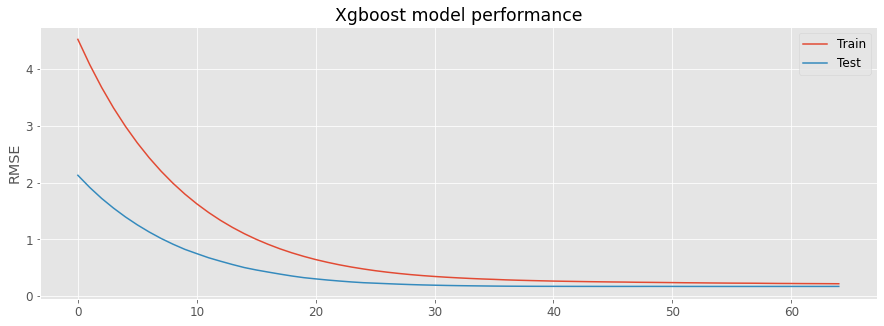

In [0]:
print('\033[4mModel performance :: Regression Quality\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = reg2.evals_result_
x_axis = range(len(history['validation_0']['rmse']))
plt.plot(x_axis, history['validation_0']['rmse'], label = 'Train')
plt.plot(x_axis, history['validation_1']['rmse'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('RMSE')
plt.title('Xgboost model performance')
plt.show()

### ***Feature importance plot***

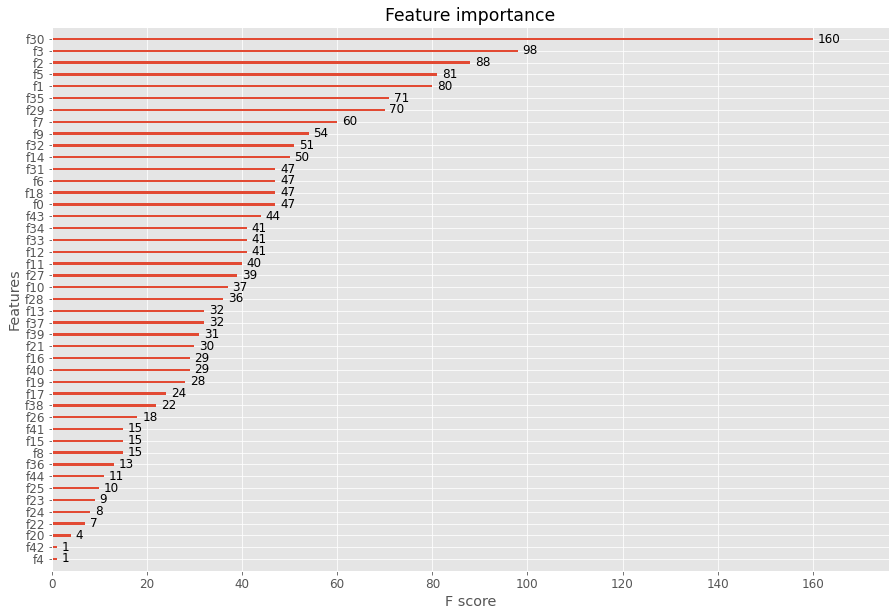

In [0]:
# Feature importance
plt.rcParams['figure.figsize'] = [15, 10]
plot_importance(reg2)
print('\n')

### ***Confidence on Test data***

In [0]:
open_confidence = reg2.score(X3_test, y3_test)
print("open_confidence %: ", round(open_confidence*100,2))

open_confidence %:  87.88


### ***5 days Open prediction***

In [0]:
forecast_pred_2 = reg2.predict(X3_forecast)
#print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_2)
print('\n')

rmse1 = np.sqrt(mean_squared_error(y3_test[:future_pred], forecast_pred_2[:future_pred]))
print('Test RMSE: %.3f' % rmse1)


[1.8511606 1.859816  1.854141  1.854141  1.854142 ]




<IPython.core.display.Javascript object>

Test RMSE: 1.387


### ***Assigning date to predicted values***

In [0]:
# assigning date to the predicted values
merge16['open_pred'] = np.nan
last_date = merge16.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_2:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  merge16.loc[next_date] = [np.nan for _ in range(len(merge16.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(merge16['open_pred'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=merge16['open_pred'].index[0].date(), end=merge16['open_pred'].index[-1].date())

#Filter the series to just those days contained in the business day range.
merge16['open_pred'] = round(merge16.open_pred[ts_days.isin(bdays)],2)
print('\033[4mExpected Open price for next 5 days\033[0m')
merge16['open_pred'].tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Open price for next 5 days


Date
2020-04-07    1.85
2020-04-08    1.86
2020-04-09    1.85
2020-04-10    1.85
2020-04-11     NaN
Name: open_pred, dtype: float64

## **5 days look-ahead Close price**

### ***Feature Engineering (Close variable)***

In [0]:
## 5 days look-ahead Open price

# Technical indicators
merge15 = merge12.apply(copy.deepcopy)

merge15['pct_change'] = merge15['Last'].pct_change()
merge15["vol_rel_increment"] = merge15['Volume'].diff() / merge15['Volume']
merge15['std_5'] = merge15['pct_change'].rolling(5).std()
merge15['ret_5'] = merge15['pct_change'].rolling(5).mean()
merge15['sma42'] = merge15['Last'].rolling(42).mean()
merge15['sma252'] = merge15['Last'].rolling(252).mean()
merge15['ema_12'] = merge15['Last'].ewm(span=10).mean()
merge15['ema_26'] = merge15['Last'].ewm(span=26).mean()
merge15['ROC'] = ((merge15['Last'] - merge15['Last'].shift(5)) / (merge15['Last'].shift(5)))*100

delta = merge15['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge15['rsi'] = 100-100/(1+RS_up/RS_down)
merge15['macd'] = merge15['ema_12'] - merge15['ema_26']

df3 = merge15.apply(copy.deepcopy)

# WINDOW FEATURE

df3['t-2'] = df3['Last'].shift(3)
df3['t-1'] = df3['Last'].shift(2)
df3['t+1'] = df3['Last'].shift(1)

# ROLLING WINDOW FEATURE

width = 3
shifted = df3['Last'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df3['min'] = roll_window.min()
df3['mean'] = roll_window.mean()
df3['max'] = roll_window.max()

# EXPANDING WINDOW STATISTICS

exp_window = df3['Last'].expanding()
df3['min_exp'] = exp_window.min()
df3['mean_exp'] = exp_window.mean()
df3['max_exp'] = exp_window.max()

### ***Information on dataframe***

In [0]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5079 entries, 2000-01-04 to 2020-04-06
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5079 non-null   float64
 1   High                        5079 non-null   float64
 2   Low                         5079 non-null   float64
 3   Last                        5079 non-null   float64
 4   Change                      5079 non-null   float64
 5   Settle                      5079 non-null   float64
 6   Volume                      5079 non-null   float64
 7   Previous Day Open Interest  5079 non-null   float64
 8   gdp                         5079 non-null   float64
 9   wti                         5079 non-null   float64
 10  withdrawals                 5079 non-null   float64
 11  storage                     5079 non-null   float64
 12  prod                        5079 non-null   float64
 13  consumption    

### ***Close Price Predictior variable***

In [0]:
# A variable for predicting 'n' days out into the future
n = int(5) #'n=5' days
pred_future = n 

#Create another column (the target or dependent variable) shifted 'n' units up
df3['prediction'] = df3['Last'].shift(-pred_future)

#print the new data set
#print(df4)

### ***Time-series cross validation (Close)***

In [0]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, random_state=42)

tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X2):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X2_train, X2_test = X2[train_index], X2[test_index]
  y2_train, y2_test = y2[train_index], y2[test_index]


### ***Setting up unseen data (Close price)***

In [0]:
X2 = np.array(df3.drop(columns = ['prediction',
                                  'day_of_week',
                                  'Change',
                                  'min_exp'], axis=1))
                         
#X2 = np.array (df3.drop(['Prediction'],1))
X2_forecast = X2[-pred_future:] # set X2_forecast equal to last 5, we do not have y2 values for X2_forecast
X2 = X2[:-pred_future] # remove last 5 from X2
y2 = np.array(df3['prediction'])
y2 = y2[:-pred_future]
#print(len(X2), len(y2))
  
eval_set = [(X2_train, np.ravel(y2_train)), (X2_test, np.ravel(y2_test))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***Fitting model and validation***

In [0]:
reg1 = xgb.XGBRegressor(objective ='reg:squarederror',
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1, 
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 100,
                        random_state = 42)


reg1.fit(X2_train, y2_train, 
         eval_metric = 'rmse', 
         eval_set = eval_set,
         early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-rmse:4.51218	validation_1-rmse:2.1281
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.62835	validation_1-rmse:0.750947
[20]	validation_0-rmse:0.654185	validation_1-rmse:0.307573
[30]	validation_0-rmse:0.360277	validation_1-rmse:0.205592
[40]	validation_0-rmse:0.281734	validation_1-rmse:0.192887
[50]	validation_0-rmse:0.255284	validation_1-rmse:0.190092
[60]	validation_0-rmse:0.237485	validation_1-rmse:0.189412
[70]	validation_0-rmse:0.226908	validation_1-rmse:0.188941
Stopping. Best iteration:
[69]	validation_0-rmse:0.227689	validation_1-rmse:0.188893



XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### ***Regression quality check***

Model performance :: Regression Quality


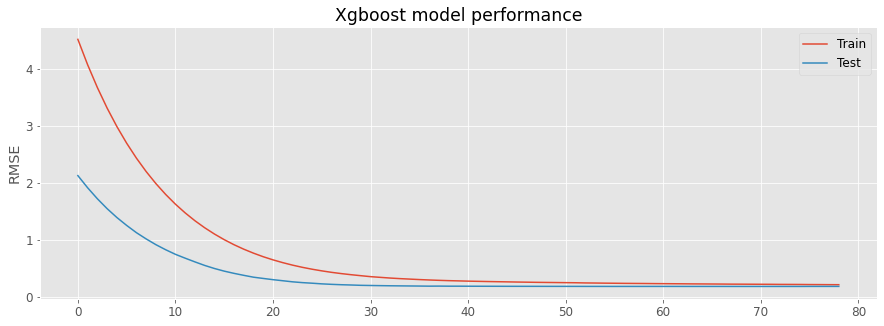

In [0]:
print('\033[4mModel performance :: Regression Quality\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = reg1.evals_result_
x_axis = range(len(history['validation_0']['rmse']))
plt.plot(x_axis, history['validation_0']['rmse'], label = 'Train')
plt.plot(x_axis, history['validation_1']['rmse'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('RMSE')
plt.title('Xgboost model performance')
plt.show()

### ***Feature importance***

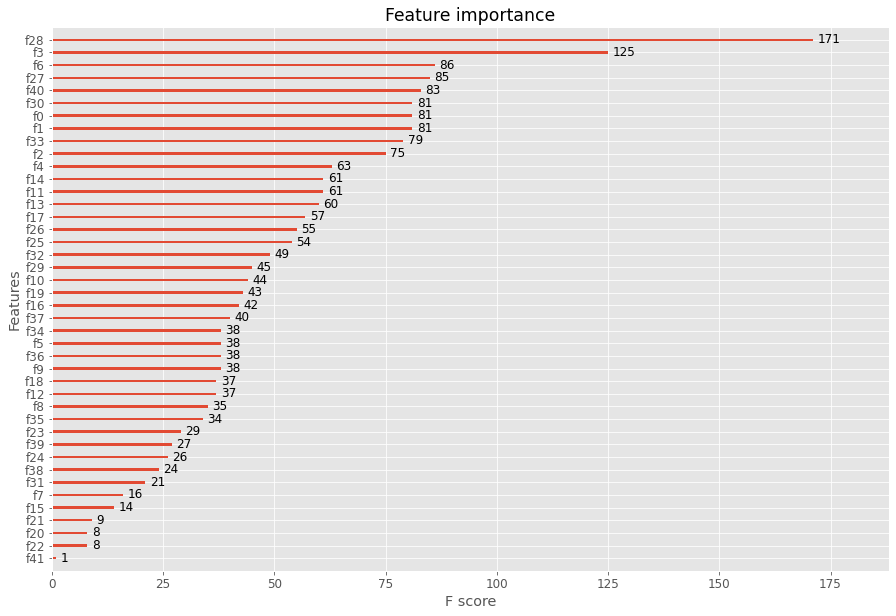

In [0]:
# Feature importance
plt.rcParams['figure.figsize'] = [15, 10]
plot_importance(reg1)
print('\n')

### ***Confidence check on test data***

In [0]:
close_confidence = reg1.score(X2_test, y2_test)
print("close_confidence %: ", round(close_confidence*100,2))

close_confidence %:  85.71


In [0]:
forecast_pred_1 = reg1.predict(X2_forecast)
#print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_1)
print('\n')

rmse2 = np.sqrt(mean_squared_error(y2_test[:pred_future], forecast_pred_1[:pred_future]))
print('Test RMSE: %.3f' % rmse2)

[1.8904866 1.9247174 1.9037837 1.9101361 1.9006038]




<IPython.core.display.Javascript object>

Test RMSE: 1.398


### ***Assigning date to Close predcited***

In [0]:
# assigning date to the predicted values
merge15['close_pred'] = np.nan
last_date = merge15.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_1:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  merge15.loc[next_date] = [np.nan for _ in range(len(merge15.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(merge15['close_pred'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=merge15['close_pred'].index[0].date(), end=merge15['close_pred'].index[-1].date())

#Filter the series to just those days contained in the business day range.
merge15['close_pred'] = merge15.close_pred[ts_days.isin(bdays)]
print('\033[4mExpected Close price for next 5 days\033[0m')
round(merge15['close_pred'],2).tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Close price for next 5 days


Date
2020-04-12     NaN
2020-04-13    1.92
2020-04-14    1.90
2020-04-15    1.91
2020-04-16    1.90
Name: close_pred, dtype: float64

## **Predicted open/close price in a data frame**

In [0]:
h_stack = pd.concat([merge16['open_pred'], merge15['close_pred']], axis=1)
h_stack.tail()


<IPython.core.display.Javascript object>

,open_pred,close_pred
Date,,
2020-04-07,1.85,1.890487
2020-04-08,1.86,1.924717
2020-04-09,1.85,1.903784
2020-04-10,1.85,1.910136
2020-04-11,NaN,NaN


#**Week, month, year historical analysis**

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG1 = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG1 = NG1.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG1.reset_index(level=0, inplace=True)
#print(NG1)
#print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
#print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
#print('\033[4mPrint last 5 rows\033[0m')
NG1['week_no'] = NG1['Date'].dt.week
NG1['month_no'] = NG1['Date'].dt.month
NG1['year'] = NG1['Date'].dt.year
NG1['DayofWeek'] = NG1['Date'].dt.dayofweek
#print(NG1.tail())
#print('\n')

Natural Gas continuous contract 1
Print 1st & last 5 rows


### ***Plot (average price in 2019)***

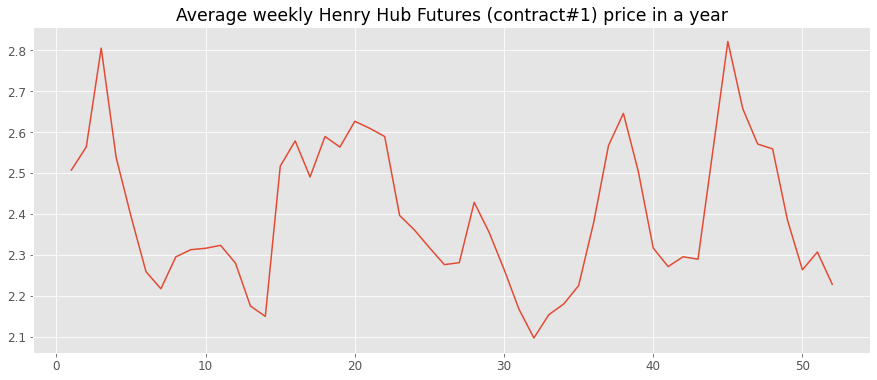

The plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.


In [0]:
fig = plt.figure(figsize=(15,6))
plt.plot(NG1[NG1.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')


### ***Average weekly prices***

In [0]:
# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG1.pivot_table(values = 'Last', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(pivot_ng.tail()) # last 5 rows
print('\n')

Average Weekly Gas Prices Pivot Table
Print last 5 rows


<IPython.core.display.Javascript object>

year        2000      2001    2002    2003    2004      2005     2006     2007     2008     2009     2010    2011     2012     2013    2014  \
week_no                                                                                                                                       
49       8.05180  2.564200  4.3266  5.8180  7.2954  14.03100  7.69000  7.20780  6.22680  4.63700  4.46780  3.4286  3.60940  4.03400  3.8252   
50       8.18080  2.774200  4.8154  6.8342  6.7912  14.46240  7.49880  7.14860  5.58340  5.08880  4.20220  3.1846  3.38300  4.31320  3.6764   
51       9.27280  2.708000  5.2178  6.9596  7.2384  13.52000  6.87240  7.13640  5.57940  5.57340  4.13275  3.1324  3.40180  4.33900  3.6518   
52       9.70525  2.746667  5.0530  6.2820  6.8240  11.22525  5.85775  7.15725  5.69175  5.71200  4.27160  3.0530  3.39025  4.42975  3.0715   
53           NaN       NaN     NaN     NaN  6.2310       NaN      NaN      NaN      NaN  5.77125      NaN     NaN      NaN      NaN     NaN   

### ***AVerage monthly prices***

In [0]:
# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG1.pivot_table(values= 'Last', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(monthly) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(monthly)
print('\n')



Average Monthly Gas Prices


<IPython.core.display.Javascript object>

year          2000      2001      2002      2003      2004       2005      2006      2007       2008      2009      2010      2011      2012  \
month_no                                                                                                                                       
1         2.385368  7.825905  2.190571  5.381429  6.278895   6.186250  9.135950  6.684591   7.991476  5.071000  5.596778  4.498300  2.707800   
2         2.614250  5.680316  2.270211  6.657579  5.363000   6.203105  7.520632  7.563800   8.642250  4.389500  5.238222  4.035526  2.525950   
3         2.828261  5.197909  3.013800  5.786286  5.542522   7.042727  6.979348  7.227318   9.638579  4.002136  4.300000  4.060818  2.296857   
4         3.028842  5.189500  3.437955  5.358667  5.765952   7.150524  7.479400  7.610450  10.288091  3.561381  4.083619  4.280263  2.067143   
5         3.596409  4.244545  3.563591  5.926667  6.398650   6.486143  6.372818  7.792391  11.422650  3.932350  4.154050  4.336143  2.49

### ***Monthly volatility***

In [0]:
print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(monthly_change)
 

Average monthly gas prices % change
year          2000      2001      2002      2003      2004      2005      2006      2007      2008      2009      2010      2011      2012  \
month_no                                                                                                                                     
1        -0.724268 -0.095381 -0.184576  0.112303 -0.029351 -0.093988 -0.319485 -0.059561  0.113205 -0.123849  0.047185  0.050558 -0.165877   
2         0.095952 -0.274165  0.036355  0.237140 -0.145869  0.002725 -0.176809  0.131528  0.081433 -0.134392 -0.064065 -0.102877 -0.067158   
3         0.081863 -0.084926  0.327542 -0.130872  0.033474  0.135355 -0.071973 -0.044486  0.115286 -0.088248 -0.179111  0.006267 -0.090696   
4         0.070920 -0.001618  0.140737 -0.073902  0.040312  0.015306  0.071647  0.053012  0.067387 -0.110130 -0.050321  0.054040 -0.100012   
5         0.187387 -0.182090  0.036544  0.105997  0.109730 -0.092914 -0.147951  0.023907  0.110279  0.104164  0.

### ***Raise vs Decline***

In [0]:
print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])

Probabilities of Monthly Gas Price Decline vs Raise
Probability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.
year      raise  decline
month_no                
1          0.35     0.70
2          0.35     0.70
3          0.50     0.55
4          0.65     0.40
5          0.70     0.30
6          0.55     0.45
7          0.20     0.80
8          0.25     0.75
9          0.50     0.50
10         0.60     0.40
11         0.55     0.45
12         0.40     0.60


# **Dash-Board**

### ***Experimentation lab !!!***

In [0]:
!pip install dash
import dash
import dash_core_components as dcc
import dash_html_components as html

import plotly.graph_objs as go
from dash.dependencies import Input, Output

app = dash.Dash()
server = app.server

### ***Section 1***

- We set-up our App and its layout using the code shown below. 

- The layout is stored in app.layout, and all the desired HTML components such as Div, H1, H2, P, etc have been added using the dash_html_components (html) library. 

- Finally, we can add interactive components to our dashboard (eg. tabs, dropdowns, radio buttons) using the dash_core_components (dcc) library.

- We have divided this Dashboard into two tabs. 
  - The first one, will be analysed the Gas Prices dataset and 
  - the second one the Henry Hub Spot dataset. 
  
The layout of the first tab is subsequently divided into other two parts each of them formed by an H1 title, 
- a dropdown menu with four different options and
- a time-series graph. 

The second tab is instead formed by just an H1 title, a dropdown menu with Henry Shub Spot price.

In [0]:
app.layout = html.Div([

    # Setting the main title of the Dashboard

    html.H1("Natural Gas Data Analysis", style={"textAlign": "center"}),

    # Dividing the dashboard in tabs

    dcc.Tabs(id="tabs", children=[

        # Defining the layout of the first Tab

        dcc.Tab(label='Natural Gas Contract Prices', 
                children=[html.Div([html.H1("Daily Price (USD / Mbtu)", 
                                            style={'textAlign': 'center'}),

                # Adding the first dropdown menu and the subsequent time-series graph

                dcc.Dropdown(id='my-dropdown1',
                             options=[{'label': 'Natural Gas', 'value': 'Daily Price'},
                                      {'label': 'Volume','value': 'Volume'}],
                             multi=True, value=['NG'],
                             style={"display": "block", 
                                    "margin-left": "auto",
                                    "margin-right": "auto", 
                                    "width": "60%"}),
                            
                          
                dcc.Graph(id='dailyprices')],
                className="container"),

        ]),


        # Defining the layout of the second tab

        dcc.Tab(label='Henry Hub Spot Price', 
                children=[html.H1("Daily Price (USD / Mbtu", 
                                  style={"textAlign": "center"}),

            # Adding a dropdown menu and the subsequent graph

            html.Div([html.Div([dcc.Dropdown(id='my-dropdown2',
                                             options=[{'label': 'Henry Hub', 'value': 'hh_spot'}],
                                             multi=True, value=['hh_spot'],
                                             style={"display": "block", 
                                                    "margin-left": "auto",
                                                    "margin-right": "auto", 
                                                    "width": "60%"}),

                    dcc.Graph(id='my-graph2'),

        ])

    ])

])

### ***Section 2***

Once Dashboard layout defined, we can then go on and design the graphs and their interaction with the dropdown menus. 

The graphs designed creating functions and the dropdown menus designed using callbacks.

The code below can be divided in : 
- Open Gas Prices Time Series graph
- Close Gas Prices Time Series graph
- a High Gas Prices Time Series graph,
- a Low Gas Prices Time Series graph,
- Adj close Prices Time Series graph, 
- a Market Volume Time Series graph and 
- Henry Hub Spot price.

In each of the sections, the callbacks (@app.callback) are used to take the selected values from the dropdowns, send them as input to the graph function and then take the variable returned by the function to pass it to the graph declared in the layout. These callbacks will automatically get called every-time the values in the dropdowns changes. The callbacks can automatically identify which of the different dropdowns available on the Dashboard changed value and which graph to subsequently update thanks to the unique id values set before in the Dashboard Layout.

Each of the three functions shown below use Plotly syntax to create the graphs. 

In [0]:
@app.callback(Output('highlow', 'figure'),[Input('my-dropdown', 'value')])

def update_graph(selected_dropdown):

    dropdown = {"HH": "Henry Hub","NG": "Natural Gas",}
    trace1 = []
    trace2 = []

    for stock in selected_dropdown:

        trace1.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))

        trace2.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))

    traces = [trace1, trace2]

    data = [val for sublist in traces for val in sublist]

    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title= f"High & Low Prices for {','.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",

            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 
                                                       'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 
                                                       'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},'rangeslider': {'visible': True}, 'type': 'date'},

             yaxis={"title":"Price (USD)"})}

    return figure



@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])

def update_graph(selected_dropdown_value):

    dropdown = {"HH": "Henry Hub","NG": "Natural Gas",}

    trace1 = []

    for stock in selected_dropdown_value:

        trace1.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))

    traces = [trace1]

    data = [val for sublist in traces for val in sublist]

    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],

            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 
                                                       'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 
                                                       'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},

                   'rangeslider': {'visible': True}, 'type': 'date'},

             yaxis={"title":"Transactions Volume"})}

    return figure


Finally, we can start a local server and make our application run by using the following code.

In [0]:
if __name__ == '__main__':
    app.run_server(debug=True)